#  Introduction to Dataset

**From https://www.kaggle.com/mlg-ulb/creditcardfraud/home :** 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

**PCA Features:**

It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA.

**Time:**

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 

**Amount:** 

The feature 'Amount' is the transaction Amount.

**Class:**

Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Other Libraries
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")


data = pd.read_csv('../input/creditcard.csv',sep=',')
data.head()

Using TensorFlow backend.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis

In [2]:
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
data.shape

(284807, 31)

## Checking for Missing Data.
- Fortunately, data integrity is perfect. All non-null, and no mixed types.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

## Class Imbalance
- This is the most unique quality about this dataset. Most of the steps taken later will be about multiple ways of dealing with imbalanced data.

Distribuition of Normal(0) and Frauds(1): 
0    284315
1       492
Name: Class, dtype: int64

Non-Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


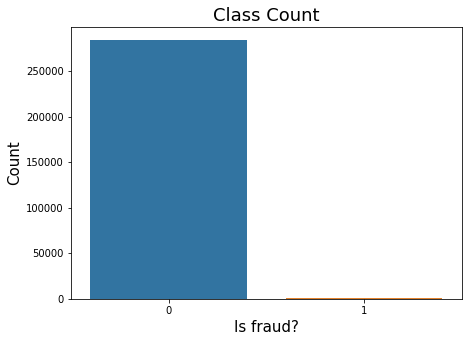

In [5]:
#Lets start looking the difference by Normal and Fraud transactions
print("Distribuition of Normal(0) and Frauds(1): ")
print(data["Class"].value_counts())
print('')

# The classes are heavily skewed we need to solve this issue later.
print('Non-Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

plt.figure(figsize=(7,5))
sns.countplot(data['Class'])
plt.title("Class Count", fontsize=18)
plt.xlabel("Is fraud?", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

## Visualizing distributions. 
- Features have different central tendencies and need to be normalized to make better sense of them.
- 'Time' is encoded in seconds, out of a 24Hr day. We'll need to transform it in order to visualize it properly.

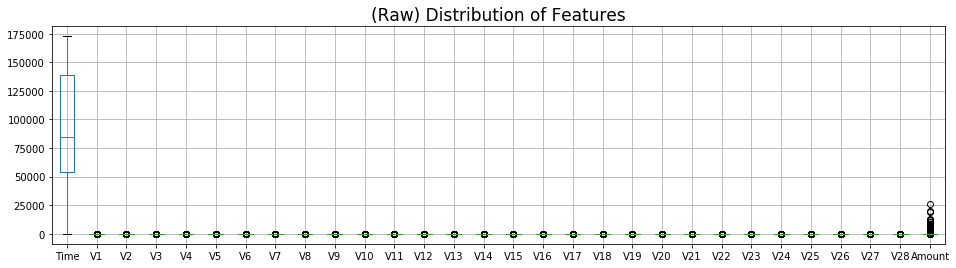

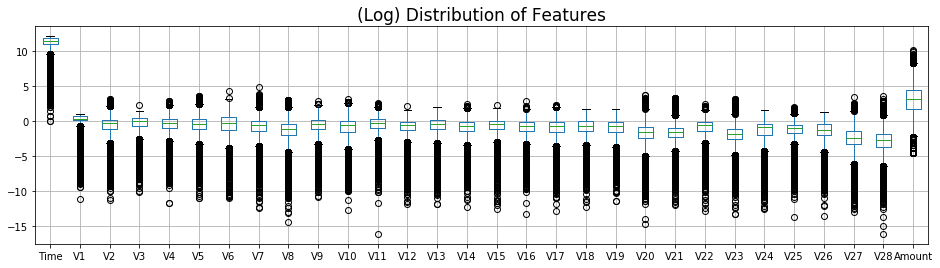

In [6]:
plt.figure(figsize=(16,4))
data.iloc[:,:-1].boxplot()
plt.title('(Raw) Distribution of Features', fontsize=17)
plt.show()

plt.figure(figsize=(16,4))
np.log(data.iloc[:,:-1]).boxplot()
plt.title('(Log) Distribution of Features', fontsize=17)
plt.show()

- It's clear that `Time` and `Amount` are in a different range compared to the `PCA` features.

## 'Amount' Distribution

- Variable isn't normalized.
- There's high concentrations of small-amount transactions. And many dispersed large-amount outliers, all the way up to \$25,000
- 85\% of data is below \$140
- Top 1% of transaction amounts are between 1017.97 and 25691.16

**Amount of frauds**
- 80% of Frauds are less than: \$152.34.

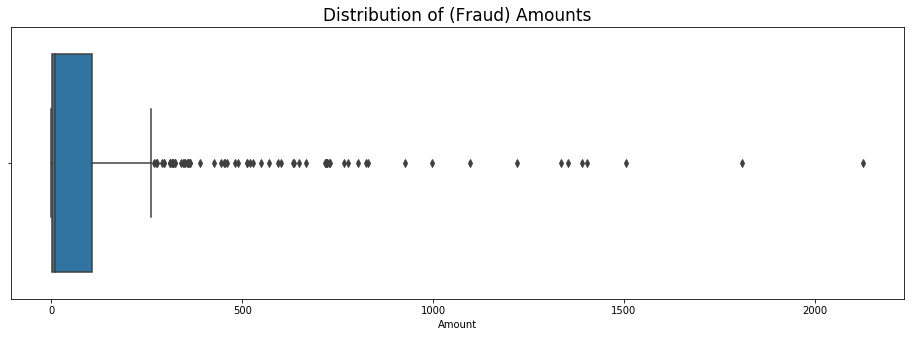

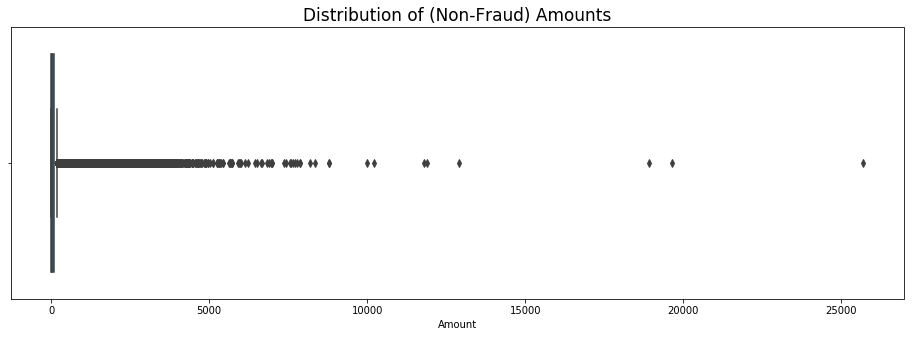

In [7]:
#Now look at Fraud Amounts
plt.figure(figsize=(16,5))
sns.boxplot(x=data.Amount[data.Class == 1])
plt.title('Distribution of (Fraud) Amounts',fontsize=17)
plt.show()
#Now look at Non-Fraud Amounts
plt.figure(figsize=(16,5))
sns.boxplot(x=data.Amount[data.Class == 0])
plt.title('Distribution of (Non-Fraud) Amounts',fontsize=17)
plt.show()

In [8]:
print('Top 85% of transaction amounts:', round(data.Amount.quantile(.85),2))
print('Top 1% of transaction amounts:', round(data.Amount.quantile(.99),2))
print('Largest transaction amount:', round(data.Amount.quantile(1),2))
print('80% of Frauds are less than:', round(data.Amount[data.Class==1].quantile(.80),2))

Top 85% of transaction amounts: 140.0
Top 1% of transaction amounts: 1017.97
Largest transaction amount: 25691.16
80% of Frauds are less than: 152.34


## 'Time' Distribution
- I'll convert 'Time' to hours and minutes, which will allow for better visualization.
- 'Time' distribution (by second) shows two normal curves, which might reveal something meaningful for predicting purposes. This will be the basis for a time-based feature engineering.

Text(0, 0.5, 'Amount')

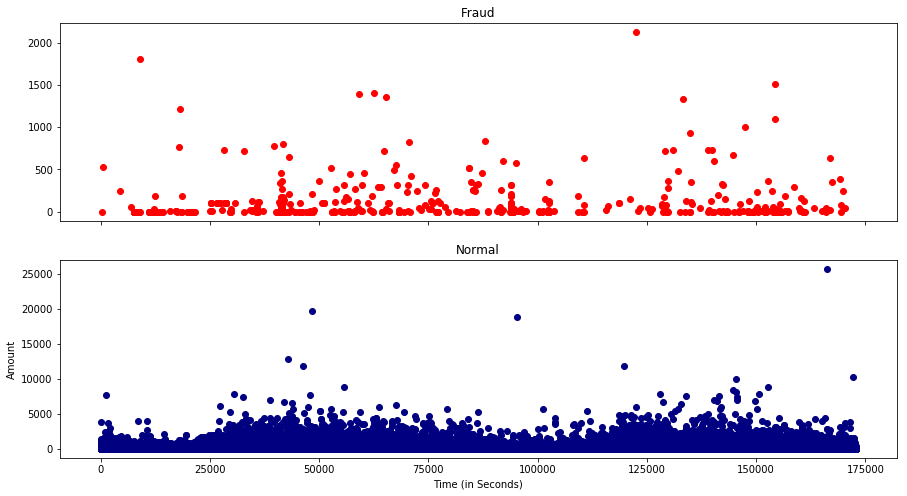

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))

ax1.scatter(data.Time[data.Class == 1],
            data.Amount[data.Class == 1], color='red')
ax1.set_title('Fraud')

ax2.scatter(data.Time[data.Class == 0],
            data.Amount[data.Class == 0],  color='navy')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')

In [10]:
# Create a EDA dataframe for the time units and visualizations
eda = pd.DataFrame(data.copy())

# Tell timedelta to interpret the Time as second units
timedelta = pd.to_timedelta(eda['Time'], unit='s')

# Create a hours feature from timedelta
eda['Time_hour'] = (timedelta.dt.components.hours).astype(int)

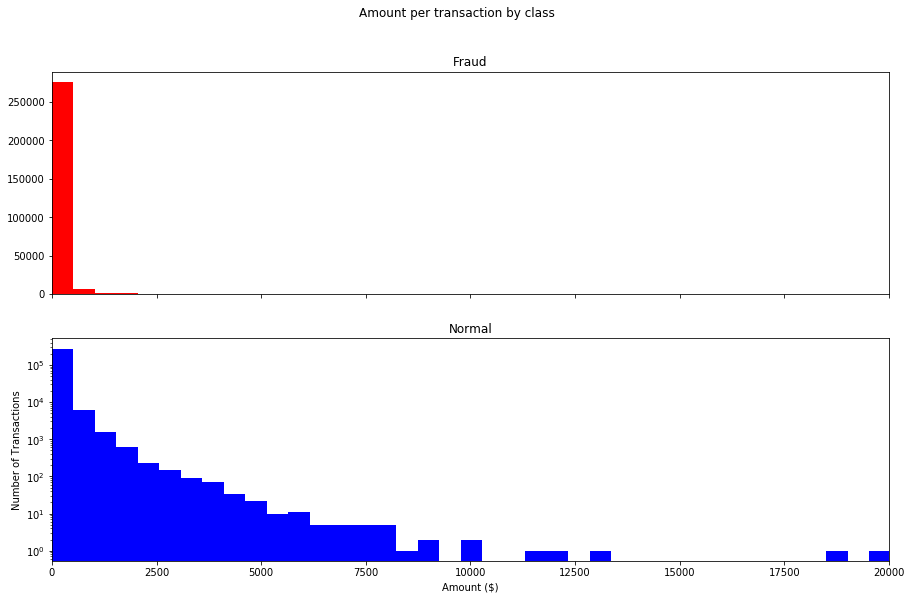

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(data[data['Class']==0].Amount, bins = bins, color='red')
ax1.set_title('Fraud')

ax2.hist(data[data['Class']==0].Amount, bins = bins, color='blue')
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

#  Modeling Outcome of Interest

## The Problem of Imbalanced Data (How NOT to do it...)

- Here I'll do a base-line prediction of frauds using default settings on the data without any modifications.
- This serves to show the need for techniques on Class Imbalance.
---
**Approach**
- Below I split data into train and test groups. 
- I'll make sure the groups maintain the same class balance as the whole set. That way they can better represent the whole, for testing purposes.

In [12]:
# Define outcome and predictors to split into train and test groups
y = data['Class']
X = data.drop('Class', 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Class balance in test group
print("TEST GROUP")
print('Size:',y_test.count())
print("Frauds percentage:",
      y_test.value_counts()[1]/y_test.count())
print("Nonfrauds percentage:",
      y_test.value_counts()[0]/y_test.count())

# Class balance in train group
print("\nTRAIN GROUP")
print('Size:',y_train.count())
print("Frauds percentage:",
      y_train.value_counts()[1]/y_train.count())
print("Nonfrauds percentage:",
      y_train.value_counts()[0]/y_train.count())

TEST GROUP
Size: 56962
Frauds percentage: 0.0017204452090867595
Nonfrauds percentage: 0.9982795547909132

TRAIN GROUP
Size: 227845
Frauds percentage: 0.001729245759178389
Nonfrauds percentage: 0.9982707542408216


TRAIN GROUP

Cross-validation accuracy scores: [0.99906516 0.99897298 0.99873598]
Mean score: 0.9989247069698471

TEST GROUP

Accuracy score: 0.9989993328885924

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.53      0.65        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.91      0.77      0.82     56962
weighted avg       1.00      1.00      1.00     56962



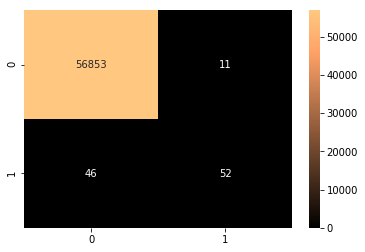

In [13]:
# Invoke classifier
clf = LogisticRegression()

# Cross-validate on the train data
train_cv = cross_val_score(X=X_train,y=y_train,estimator=clf,cv=3)
print("TRAIN GROUP")
print("\nCross-validation accuracy scores:",train_cv)
print("Mean score:",train_cv.mean())

# Now predict on the test group
print("\nTEST GROUP")
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("\nAccuracy score:",clf.score(X_test,y_test))

# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()


**Understanding the scores**

Sensitivity (or Recall) is the percentage of positives correctly identified.

Specificity is just the opposite, the percentage of negatives correctly identified.

The confusion matrix and classification reports reveal that **the high scores are merely a reflection of the class imbalance.** Since we're using a generalized scoring method, accuracy reflects the recall of both frauds and non-frauds. However, since frauds are so few,(`0.0017%`) their poor recall(`53%`) isn't reflected in the overall accuracy score.

**On the test set**
- Of `98` fraud cases in the test set, `52` were correctly labeled as frauds. And almost a half, `46` were mislabeled as non-frauds.
- All except `11` non-frauds were correctly labeled as non-frauds, from a total of `56,864`. That's nearly perfect, but the priority should be to prevent frauds. Therefore, this is rather a secondary metric for us.

## Feature Engineering

**Before fixing the class imbalance, there are other things that need to be addressed:**
- Classification algorithms expect to receive normalized features. There are two features in the data that aren't normalized. ('Time' and 'Amount')
- New features could be created from those unprocessed features, if they capture a pattern correlated to 'Class'.

**'Features' DataFrame**
- In this dataframe I'll store the features intended for predictive modeling of frauds.
- 'data' will be left as the raw dataset.

In [14]:
features = pd.DataFrame()

### Time-Based Features
- There seem to be two normal distributions in the feature Time. Let's isolate them so we can create features from them.

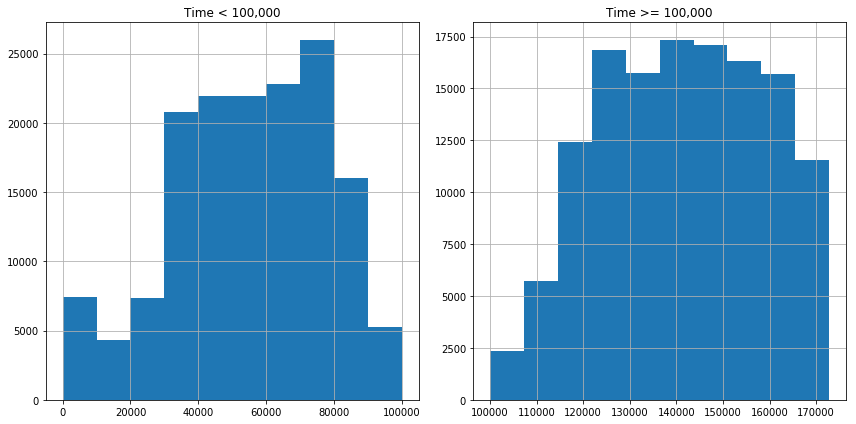

In [15]:
plt.figure(figsize=(12,6))

# Visualize where Time is less than 100,000
plt.subplot(1,2,1)
plt.title("Time < 100,000")
data[data['Time']<100000]['Time'].hist()

# Visualize where Time is more than 100,000
plt.subplot(1,2,2)
plt.title("Time >= 100,000")
data[data['Time']>=100000]['Time'].hist()

plt.tight_layout()
plt.show()

In [16]:
# Create a feature from normal distributions above
features['100k_time'] = np.where(data.Time<100000, 1,0)

### Feature: Time_hour > 4
- Feature for non-frauds, where 'Time_hour' is above 4. This seems to have a clear differentiation.

In [17]:
eda = pd.DataFrame(data.copy())

# Tell timedelta to interpret the Time as second units
timedelta = pd.to_timedelta(eda['Time'], unit='s')

# Create a hours feature from timedelta
eda['Time_hour'] = (timedelta.dt.components.hours).astype(int)

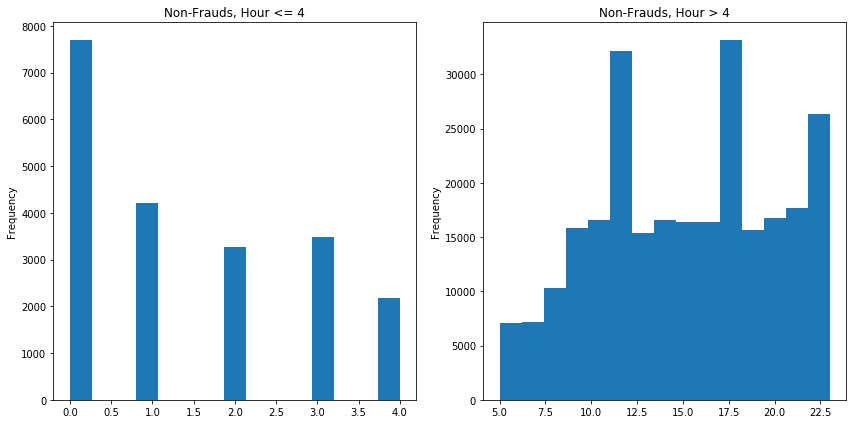

In [18]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Non-Frauds, Hour <= 4")
eda.Time_hour[(eda.Class == 0) & (eda.Time_hour <= 4)].plot(kind='hist',bins=15)

plt.subplot(1,2,2)
plt.title("Non-Frauds, Hour > 4")
eda.Time_hour[(eda.Class == 0) & (eda.Time_hour > 4)].plot(kind='hist',bins=15)

plt.tight_layout()
plt.show()

In [19]:
# Create a feature from distributions above
features['4_hour'] = np.where((eda.Class == 0) & (eda.Time_hour > 4), 1,0)

### Feature: $0 Fraud Amounts...?
- Many transactions are zero dollars. This might be confusing for our model's predictive ability. It is arguable these don't need to be prevented. 
    - One approach could be to simply discard these transactions. 
    - The second approach is to ignore it and focus on predicting transactions labeled as 'frauds', regardless of them having no dollar-value.
    
**For now, I'll use this as basis for a feature. Later I'll compare results between different approaches**

In [20]:
# how many frauds are actually 0 dollars?
print("Non-Fraud Zero dollar Transactions:")
display(data[(data.Amount == 0) & (data.Class == 0)]['Class'].count())
print("Fraudulent Zero dollar Transactions:")
display(data[(data.Amount == 0) & (data.Class == 1)]['Class'].count())

Non-Fraud Zero dollar Transactions:


1798

Fraudulent Zero dollar Transactions:


27

In [21]:
# Capture where transactions have a $0 amount
features['amount0'] = np.where(data.Amount == 0,1,0)

### Normalize Time and Amount
- Although we already captured some features from 'Time' and 'Amount', before decidedly dropping them, I'd like to normalize and test them in the model.

In [22]:
rob_scaler = RobustScaler()

features['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
features['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

### Add the Rest: PCA and Class


In [23]:
# Add the PCA components to our features DataFrame.
features = features.join(data.iloc[:,1:-1].drop('Amount',axis=1))

# Add 'Class' to our features DataFrame.
features = features.join(data.Class)

# Nice! These are the final features I'll settle for.
features.head()

,100k_time,4_hour,amount0,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1,0,0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1,0,0,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1,0,0,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1,0,0,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,1,0,0,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Classification Improvements after Feature Engineering

- We've added some features, and re-coded two existing features. Let's see how classification performs now.
- In this classification I'll define `X` and `y`, as well as `train` and `test` samples from the `features` DataFrame, which has the feature-engineered version of the data.
- Also, I'll use `recall_score` as the scoring function for cross-validation. This represents the percentage of frauds correctly identified.

In [24]:
# Define outcome and predictors USE FEATURE-ENGINEERED DATA
y = features['Class']
X = features.drop('Class', 1)

# Split X and y into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Class balance in test group
print("TEST GROUP")
print('Size:',y_test.count())
print("Frauds percentage:",
      y_test.value_counts()[1]/y_test.count())
print("Nonfrauds percentage:",
      y_test.value_counts()[0]/y_test.count())

# Class balance in train group
print("\nTRAIN GROUP")
print('Size:',y_train.count())
print("Frauds percentage:",
      y_train.value_counts()[1]/y_train.count())
print("Nonfrauds percentage:",
      y_train.value_counts()[0]/y_train.count())

TEST GROUP
Size: 56962
Frauds percentage: 0.0017204452090867595
Nonfrauds percentage: 0.9982795547909132

TRAIN GROUP
Size: 227845
Frauds percentage: 0.001729245759178389
Nonfrauds percentage: 0.9982707542408216


TRAIN GROUP

Cross-validation recall scores: [0.79545455 0.81679389 0.85496183]
Mean recall score: 0.8224034235484617

TEST GROUP

Recall: 0.826530612244898

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.98      0.83      0.90        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962



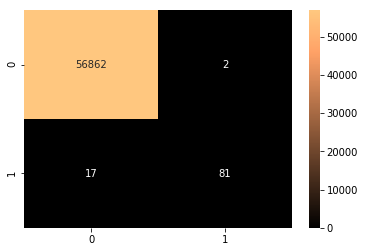

In [25]:
# Invoke classifier
clf = LogisticRegression()

# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# Cross-validate on the train data
train_cv = cross_val_score(X=X_train,y=y_train,estimator=clf,scoring=recall,cv=3)
print("TRAIN GROUP")
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())

# Now predict on the test group
print("\nTEST GROUP")
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("\nRecall:",recall_score(y_test,y_pred))

# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

**Scores**
- Now the cross_val scores reflect the fraud recall on three folds of the train data. These numbers are more informative for us now.
- The mean recall from train data is also very consistent with the test recall. This is evidence of the model's certainty.
- Fraud Recall went up from `53%` to `83%`. That's pretty good already, but it's far from perfect. We still have `17` frauds in the test set that aren't being predicted.

**What's next**
The main obstacles for high accuracy are currently class-imbalance, outliers and noise. Fixing these involves changing the length of the data, meaning we won't have the same datapoints present afterwards. For that reason, we'll only use the features' `train` data to make these transformations, and use the features' `test` data to make predictions.

## Data Processing

Data processing will include class-balancing, removing outliers, and feature-selection.

### Balancing Classes
**There's several methods for balancing classes:** Im mostly interested in these...

---
- Random-Undersampling of Majority Class.

You reduce the size of majority class to match size of minority class. Disadvantage is that you may end up with very little data.
    
---
- SMOTE- Synthetic Minority Oversampling Technique.

Algorithm that creates a larger sample of minority class to match the size of majority class.
 
---
- Inverting Class Ratios. (Turning minority into majority)

If you turn the minority into the majority, you may skew results towards better recall scores(detecting frauds correctly), as opposed to better specificity scores.(detecting non-frauds correctly)

---

**For now, I'll balance with a variant implementation of SMOTE, to see correlations.**

In [26]:
# Balancing Classes before checking for correlation

# Join the train data
train = X_train.join(y_train)

print('Data shape before balancing:',train.shape)
print('\nCounts of frauds VS non-frauds in previous data:')
print(train.Class.value_counts())
print('-'*40)

Data shape before balancing: (227845, 34)

Counts of frauds VS non-frauds in previous data:
0    227451
1       394
Name: Class, dtype: int64
----------------------------------------


In [27]:
# Oversample frauds. Imblearn's ADASYN was built for class-imbalanced datasets
X_bal, y_bal = SMOTE(random_state=0).fit_sample(
    X_train,
    y_train)

# Join X and y
X_bal = pd.DataFrame(X_bal,columns=X_train.columns)
y_bal = pd.DataFrame(y_bal,columns=['Class'])
balanced = X_bal.join(y_bal)


print('-'*40)
print('Data shape after balancing:',balanced.shape)
print('\nCounts of frauds VS non-frauds in new data:')
print(balanced.Class.value_counts())

----------------------------------------
Data shape after balancing: (454902, 34)

Counts of frauds VS non-frauds in new data:
1    227451
0    227451
Name: Class, dtype: int64


- Now we have much more data because the frauds were oversampled to match the size of non-frauds.


Distribution of the Classes in the subsample dataset
1    0.998271
0    0.998271
Name: Class, dtype: float64


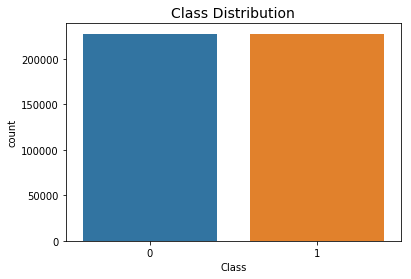

In [28]:
print('Distribution of the Classes in the subsample dataset')
print(balanced.Class.value_counts()/len(train))

sns.countplot('Class', data=balanced)
plt.title('Class Distribution', fontsize=14)
plt.show()


### Removing High-Correlation Outliers
- This step must be taken after balancing classes. Otherwise, correlations will echo class-distributions. To illustrate, I'll include two versions of the correlation matrix.
- Based on a correlation matrix, we'll identify features with high correlations, and remove any transactions with outlying values in these.
- High correlation features have a high capacity to influence the algorith prediction. Therefore it's important to control their anomalies.
- This approach will reduce prediction bias because our algorithm will learn from more normally-distributed features. 

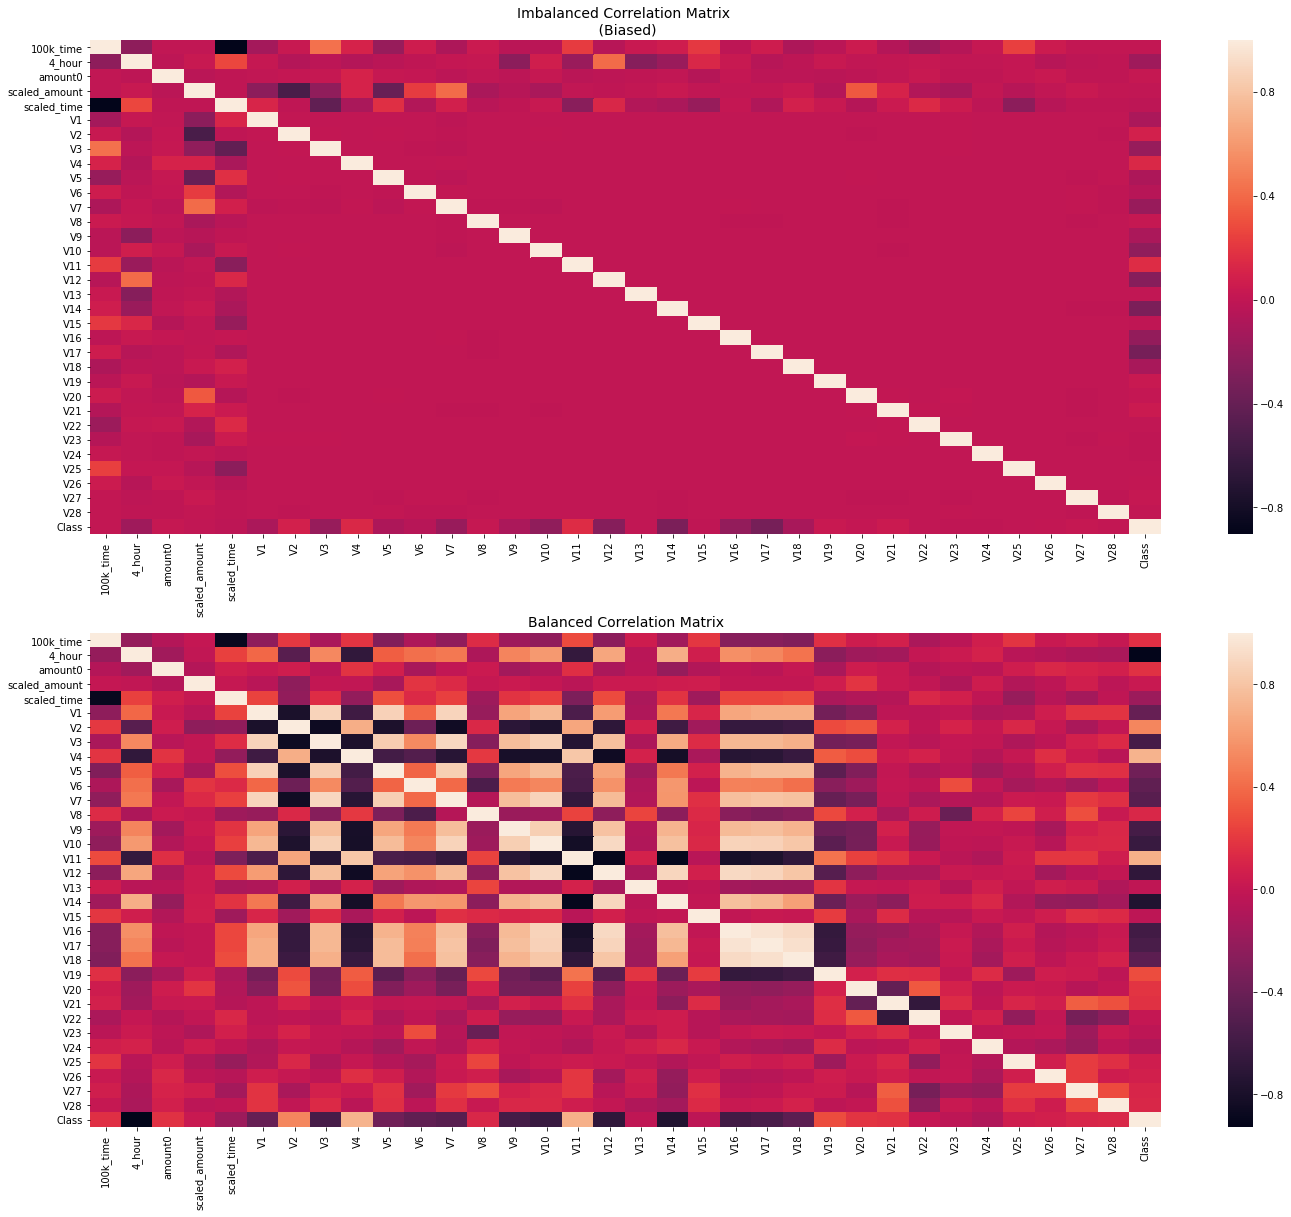

In [29]:
# Compare correlation of raw train data VS balanced train data

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Imbalanced DataFrame
corr = train.corr()
sns.heatmap(corr, annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (Biased)", fontsize=14)

# Balanced DataFrame
bal_corr = balanced.corr()
sns.heatmap(bal_corr, annot_kws={'size':20}, ax=ax2)
ax2.set_title('Balanced Correlation Matrix', fontsize=14)
plt.show()

- From the feature engineered variables, it looks like `4_hour` has a very strong (negative) correlation with 'Class'. Well, at least one was useful.
- Now let's see some actual numbers for feature correlations.

In [30]:
# Each feature's correlation with Class
bal_corr.Class

100k_time        0.156164
4_hour          -0.929015
amount0          0.164516
scaled_amount    0.025962
scaled_time     -0.176414
V1              -0.416711
V2               0.516749
V3              -0.569048
V4               0.719325
V5              -0.377100
V6              -0.449862
V7              -0.487419
V8               0.114110
V9              -0.578140
V10             -0.641454
V11              0.699998
V12             -0.687104
V13             -0.023681
V14             -0.762807
V15             -0.030614
V16             -0.591601
V17             -0.558521
V18             -0.463144
V19              0.277653
V20              0.179036
V21              0.163920
V22              0.003105
V23             -0.031218
V24             -0.090916
V25              0.055019
V26              0.068937
V27              0.109585
V28              0.116219
Class            1.000000
Name: Class, dtype: float64

- I'll make a loop that checks each feature for correlation value, and if greater than that, it'll remove outliers for that variable following a certain cutoff.

**Approach to removing outliers:**

**For features of high positive correlation...**
Remove non-fraud outliers on the top range, (improve recall) and remove fraud outliers on the bottom range. (improve specificity)

**For features of high negative correlation...**
Remove non-fraud outliers on the bottom range, (improve recall) and remove fraud outliers on the top range. (improve specificity)

In [31]:
no_outliers=pd.DataFrame(balanced.copy())

In [32]:
# Removing Outliers from high-correlation features

cols = bal_corr.Class.index[:-1]

# For each feature correlated with Class...
for col in cols:
    # If absolute correlation value is more than X percent...
    correlation = bal_corr.loc['Class',col]
    if np.absolute(correlation) > 0.1:
        
        # Separate the classes of the high-correlation column
        nonfrauds = no_outliers.loc[no_outliers.Class==0,col]
        frauds = no_outliers.loc[no_outliers.Class==1,col]

        # Identify the 25th and 75th quartiles
        all_values = no_outliers.loc[:,col]
        q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
        # Get the inter quartile range
        iqr = q75 - q25
        # Smaller cutoffs will remove more outliers
        cutoff = iqr * 7
        # Set the bounds of the desired portion to keep
        lower, upper = q25 - cutoff, q75 + cutoff
        
        # If positively correlated...
        # Drop nonfrauds above upper bound, and frauds below lower bound
        if correlation > 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds>upper].index,inplace=True)
            no_outliers.drop(index=frauds[frauds<lower].index,inplace=True)
        
        # If negatively correlated...
        # Drop nonfrauds below lower bound, and frauds above upper bound
        elif correlation < 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds<lower].index,inplace=True)
            no_outliers.drop(index=frauds[frauds>upper].index,inplace=True)
        
print('\nData shape before removing outliers:', balanced.shape)
print('\nCounts of frauds VS non-frauds in previous data:')
print(balanced.Class.value_counts())
print('-'*40)
print('-'*40)
print('\nData shape after removing outliers:', no_outliers.shape)
print('\nCounts of frauds VS non-frauds in new data:')
print(no_outliers.Class.value_counts())


Data shape before removing outliers: (454902, 34)

Counts of frauds VS non-frauds in previous data:
1    227451
0    227451
Name: Class, dtype: int64
----------------------------------------
----------------------------------------

Data shape after removing outliers: (443406, 34)

Counts of frauds VS non-frauds in new data:
0    224779
1    218627
Name: Class, dtype: int64


- Outliers from high-correlation features are now gone. However, this created a class-imbalance again. 
- I will balance the classes later when I reduce the model size. Reduction is important because classifiers may lag on high-dimensional datasets. 

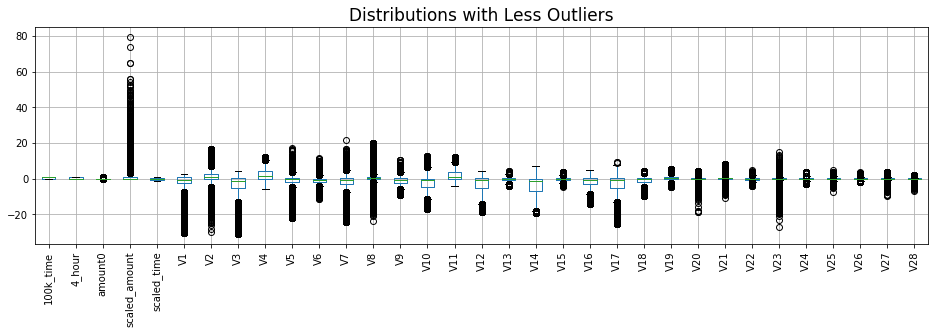

In [33]:
no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
plt.title('Distributions with Less Outliers', fontsize=17)
plt.show()

### Feature Selection

- I'll use the correlation matrix again, but this time I'll filter out features with low predictive power, instead of outliers.

But first, let's see what the outlier removal did to the correlations.

In [34]:
feat_sel =pd.DataFrame(no_outliers.copy())

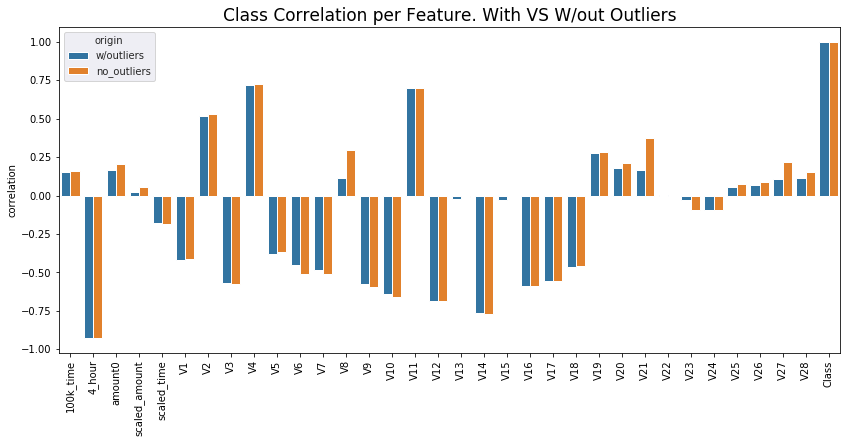

In [35]:
# Make a dataframe with the class-correlations before removing outliers
corr_change = pd.DataFrame()
corr_change['correlation']= bal_corr.Class
corr_change['origin']= 'w/outliers'

# Make a dataframe with class-correlations after removing outliers 
corr_other = pd.DataFrame()
corr_other['correlation']= feat_sel.corr().Class
corr_other['origin']= 'no_outliers'

# Join them
corr_change = corr_change.append(corr_other)

plt.figure(figsize=(14,6))
plt.xticks(rotation=90)

# Plot them
sns.set_style('darkgrid')
plt.title('Class Correlation per Feature. With VS W/out Outliers', fontsize=17)
sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
plt.show()

- It's obvious that most features gained correlation power, regardless of direction. Positive correlations went higher up, negative correlations went lower down. Also, the highest correlations flattened out, while the smallest ones rose to relevance.
- It is clearly an indicator that the outliers were causing noise, and therefore dimming the correlation-potential of each feature.

In [36]:
# Feature Selection based on correlation with Class

print('\nData shape before feature selection:', feat_sel.shape)
print('\nCounts of frauds VS non-frauds before feature selection:')
print(feat_sel.Class.value_counts())
print('-'*40)

# Correlation matrix after removing outliers
new_corr = feat_sel.corr()

for col in new_corr.Class.index[:-1]:
    # Pick desired cutoff for dropping features. In absolute-value terms.
    if np.absolute(new_corr.loc['Class',col]) < 0.1:
        # Drop the feature if correlation is below cutoff
        feat_sel.drop(columns=col,inplace=True)

print('-'*40)
print('\nData shape after feature selection:', feat_sel.shape)
print('\nCounts of frauds VS non-frauds in new data:')
print(feat_sel.Class.value_counts())


Data shape before feature selection: (443406, 34)

Counts of frauds VS non-frauds before feature selection:
0    224779
1    218627
Name: Class, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (443406, 26)

Counts of frauds VS non-frauds in new data:
0    224779
1    218627
Name: Class, dtype: int64


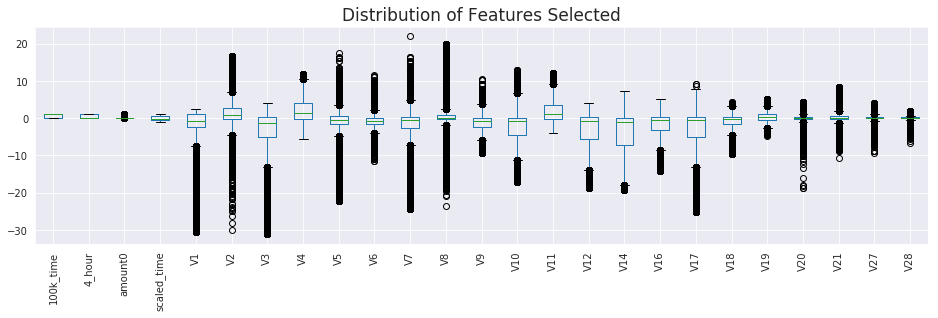

In [37]:
feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
plt.title('Distribution of Features Selected', fontsize=17)
plt.show()

- So this removed a few features from our 'processed' dataset. Aside from its large size, it should be ready for predictions.

## Test and Compare Classifiers
**Approach:**

- I'll evaluate improvements based on **fraud recall**, since its crucial to prevent frauds. This might come at the expense of more false-alarms, which would decrease the overall accuracy. **The main purpose of this project will be to identify all frauds, while minimizing false-positives.**

- I'll define outcomes and predictors, reduce model size, and classify.

In [38]:
# Undersample model for efficiency and balance classes.

X_train = feat_sel.drop('Class',1)
y_train = feat_sel.Class

# After feature-selection, X_test needs to include only the same features as X_train
cols = X_train.columns
X_test = X_test[cols]

# Undersample and balance classes
X_train, y_train = RandomUnderSampler().fit_sample(X_train,y_train)

print('\nX_train shape after reduction:', X_train.shape)
print('\nCounts of frauds VS non-frauds in y_train:')
print(np.unique(y_train, return_counts=True))


X_train shape after reduction: (437254, 25)

Counts of frauds VS non-frauds in y_train:
(array([0, 1]), array([218627, 218627]))


### First-Run: Predictions on Default Parameters

- Here, I'll try a few simple classifiers and compare their performance. 

In [39]:
# DataFrame to store classifier performance
performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])


 ---------------------------------------- 
 SVC 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [1. 1. 1.]
Mean recall score: 1.0

TEST GROUP

Recall: 0.8163265306122449


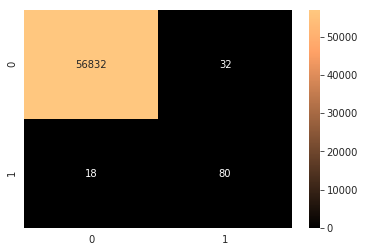


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.99400351 0.99448378 0.99377015]
Mean recall score: 0.9940858159529172

TEST GROUP

Recall: 0.9795918367346939


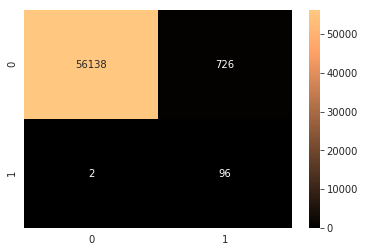


 ---------------------------------------- 
 DecisionTreeClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.99986278 0.99993139 0.9998765 ]
Mean recall score: 0.9998902239260336

TEST GROUP

Recall: 0.8367346938775511


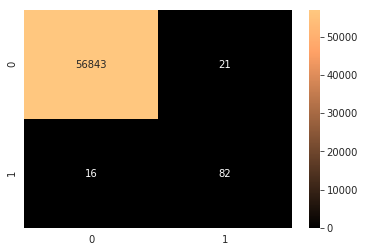


 ---------------------------------------- 
 KNeighborsClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [1. 1. 1.]
Mean recall score: 1.0

TEST GROUP

Recall: 0.8571428571428571


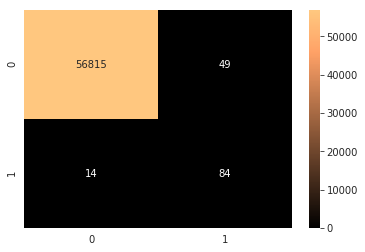

In [40]:
# Load simple classifiers
classifiers = [SVC(max_iter=1000),LogisticRegression(),
               DecisionTreeClassifier(),KNeighborsClassifier()]

# Get a classification report from each algorithm
for clf in classifiers:    
    
    # Heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
    
    # Cross-validate on the train data
    print("TRAIN GROUP")
    train_cv = cross_val_score(X=X_train, y=y_train, 
                               estimator=clf, scoring=recall,cv=3)
    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print("\nRecall:",recall_score(y_test,y_pred))
    
    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    # Store results
    performance.loc[clf.__class__.__name__+'_default',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]

In [41]:
# Scores obtained
performance

,Train_Recall,Test_Recall,Test_Specificity
SVC_default,1,0.816327,0.999437
LogisticRegression_default,0.994086,0.979592,0.987233
DecisionTreeClassifier_default,0.99989,0.836735,0.999631
KNeighborsClassifier_default,1,0.857143,0.999138


- These results are very promising for a first run, considering I didn't tweak any of the parameters.
- Now let's do a GridSearchCV to find the best parameters for these classifiers.

### Logistic Regression- GridSearch & Recall Score. 

- `GridSearchCV` compares parameter combinations to find the highest score, determined by the user. I'll set `recall_score` to be the determinant factor for the best parameter combination.

- The `class_weight` parameter greatly skews the classification emphasis from focusing on frauds at the expense of more non-fraud errors. For now, I'll prioritize fraud prevention. Later, I'll improve on specificity.

**About the parameters to optimize**
- Solvers `'newton-cg', 'lbfgs', and 'sag'` handle only `L2`-penalty. So we'll have to do this using two parameter grids: First for `L2`-only solvers, and then for `L1 and L2`-solvers.


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'} 

TRAIN GROUP

Cross-validation recall scores: [1. 1. 1.]
Mean recall score: 1.0

TEST GROUP

Recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      1.00      0.11        98

   micro avg       0.97      0.97      0.97     56962
   macro avg       0.53      0.99      0.55     56962
weighted avg       1.00      0.97      0.98     56962



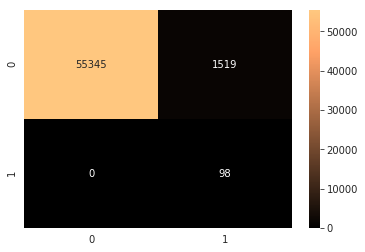

In [42]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1, # Use all CPU
    class_weight={0:0.1,1:1} # Prioritize frauds
)

# Load GridSearchCV
search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    n_jobs=-1,
    scoring=recall
)

# Train search object
search.fit(X_train, y_train)

# Heading
print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

# Extract best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, 
                           estimator=best, scoring=recall,cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())

# Now predict on the test group
print("\nTEST GROUP")
y_pred = best.fit(X_train, y_train).predict(X_test)
print("\nRecall:",recall_score(y_test,y_pred))

# Get classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()
    
# Store results
performance.loc[clf.__class__.__name__+'_search',
                ['Train_Recall','Test_Recall','Test_Specificity']] = [
    train_cv.mean(),
    recall_score(y_test,y_pred),
    conf_matrix[0,0]/conf_matrix[0,:].sum()
]

In [43]:
performance

,Train_Recall,Test_Recall,Test_Specificity
SVC_default,1,0.816327,0.999437
LogisticRegression_default,0.994086,0.979592,0.987233
DecisionTreeClassifier_default,0.99989,0.836735,0.999631
KNeighborsClassifier_default,1,0.857143,0.999138
LogisticRegression_search,1,1,0.973287


## Pyrrhic Victory- 
**A victory that inflicts such a devastating toll on the victor that it is tantamount to defeat. Someone who wins a Pyrrhic victory has also taken a heavy toll that negates any true sense of achievement.**

- Well, fraud recall improved on Logistic Regression.
- However, this has come at the cost of horribly low specificity.

- `GridSearch` allows us to see the results that informed the choice of best parameters, based on our scoring function. In this case, `recall_score`. Let's see how they compare.

In [44]:
pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head()

,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
22,0.7,l2,liblinear,"{'C': 0.7, 'penalty': 'l2', 'solver': 'libline...",1.0,1.0,1.0,1.0,0.0,1,1.0,1.0,0.999986,0.999995,0.000006
3,0.5,l2,newton-cg,"{'C': 0.5, 'penalty': 'l2', 'solver': 'newton-...",1.0,1.0,1.0,1.0,0.0,1,1.0,1.0,0.999986,0.999995,0.000006
4,0.5,l2,lbfgs,"{'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}",1.0,1.0,1.0,1.0,0.0,1,1.0,1.0,0.999986,0.999995,0.000006
26,1,l2,liblinear,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",1.0,1.0,1.0,1.0,0.0,1,1.0,1.0,0.999993,0.999998,0.000003
6,0.7,l2,newton-cg,"{'C': 0.7, 'penalty': 'l2', 'solver': 'newton-...",1.0,1.0,1.0,1.0,0.0,1,1.0,1.0,0.999993,0.999998,0.000003


- It seems like the top 5 combinations had a perfect `recall_score`, which explain why they all have a rank of `1`. This means there was no need for a real comparison for the 'best' parameters, because they all were perfect. We simply got the parameters that were first on the list of **perfect** combinations.
- Since we wanted to prioritize fraud recall, we set a very skewed `class_weight` parameter. This is why the results produced such perfect recall scores, at the expense of specificity.
- Let's find the right balance between perfect recall and higher specificity.

## Optimize Specificity while Maintaining Perfect Recall

- In this section I'll implement a few ideas to minimize false-positives (non-frauds identified as frauds), while still predicting all frauds correctly. 

### Custom Scoring Function

- Parameter search functions use a scoring parameter to determine the best parameter combination. In the previous experiments we've used recall score as the basis. Now we want to pick a parameter combination that also takes specificity into account, while ensuring perfect recall.

In [45]:
# Make a scoring function that improves specificity while identifying all frauds
def recall_optim(y_true, y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Recall will be worth a greater value than specificity
    rec = recall_score(y_true, y_pred) * 0.8 
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.2 
    
    # Imperfect recalls will lose a penalty
    # This means the best results will have perfect recalls and compete for specificity
    if rec < 0.8:
        rec -= 0.2
    return rec + spe 
    
# Create a scoring callable based on the scoring function
optimize = make_scorer(recall_optim)

- Now add the optimized scores to the existing performance DataFrame

In [46]:
scores = []
for rec, spe in performance[['Test_Recall','Test_Specificity']].values:
    rec = rec * 0.8
    spe = spe * 0.2
    if rec < 0.8:
        rec -= 0.20
    scores.append(rec + spe)
performance['Optimize'] = scores
display(performance)

,Train_Recall,Test_Recall,Test_Specificity,Optimize
SVC_default,1,0.816327,0.999437,0.652949
LogisticRegression_default,0.994086,0.979592,0.987233,0.781120
DecisionTreeClassifier_default,0.99989,0.836735,0.999631,0.669314
KNeighborsClassifier_default,1,0.857143,0.999138,0.685542
LogisticRegression_search,1,1,0.973287,0.994657


### Iteration Function

Since I'll apply the new settings to several classifiers, I'll define a function to reuse several times.
- It'll take the parameters you want to compare, and the classifier you want to try.
- It'll determine best parameters based on custom scoring, do cross-validation for recall on train data, then train and predict the test set. 
- It'll show us the recall scores for train and test, a confusion matrix, a classification report, the GridSearch' top combinations, and a view of the performance DataFrame.

In [47]:
def score_optimization(params,clf):
    # Load GridSearchCV
    search = GridSearchCV(
        estimator=clf,
        param_grid=params,
        n_jobs=-1,
        scoring=optimize
    )

    # Train search object
    search.fit(X_train, y_train)

    # Heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

    # Extract best estimator
    best = search.best_estimator_
    print('Best parameters: \n\n',search.best_params_,'\n')

    # Cross-validate on the train data
    print("TRAIN GROUP")
    train_cv = cross_val_score(X=X_train, y=y_train, 
                               estimator=best, scoring=recall,cv=3)
    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get classification report
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Store results
    performance.loc[clf.__class__.__name__+'_optimize',:] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_optim(y_test,y_pred)
    ]
    # Look at the parameters for the top best scores
    display(pd.DataFrame(search.cv_results_).iloc[:,4:].
            sort_values(by='rank_test_score').head())
    display(performance)

### LogisticRegression- Optimized.


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'C': 1, 'class_weight': {1: 1, 0: 0.3}, 'penalty': 'l1', 'solver': 'liblinear'} 

TRAIN GROUP

Cross-validation recall scores: [0.99935507 0.99935507 0.99917667]
Mean recall score: 0.9992956033841612

TEST GROUP

Recall: 0.9795918367346939
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.98      0.16        98

   micro avg       0.98      0.98      0.98     56962
   macro avg       0.54      0.98      0.57     56962
weighted avg       1.00      0.98      0.99     56962



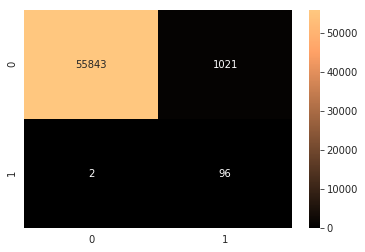

,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
72,1,"{1: 1, 0: 0.3}",l1,liblinear,"{'C': 1, 'class_weight': {1: 1, 0: 0.3}, 'pena...",0.795988,0.796125,0.795941,0.796018,0.000078,1,0.796132,0.795949,0.795982,0.796021,0.000079
60,0.7,"{1: 1, 0: 0.3}",l1,liblinear,"{'C': 0.7, 'class_weight': {1: 1, 0: 0.3}, 'pe...",0.795894,0.796117,0.795905,0.795972,0.000102,2,0.796073,0.795975,0.795949,0.795999,0.000053
48,0.5,"{1: 1, 0: 0.3}",l1,liblinear,"{'C': 0.5, 'class_weight': {1: 1, 0: 0.3}, 'pe...",0.795919,0.796092,0.795886,0.795966,0.000090,3,0.796096,0.795999,0.795942,0.796012,0.000063
36,0.3,"{1: 1, 0: 0.3}",l1,liblinear,"{'C': 0.3, 'class_weight': {1: 1, 0: 0.3}, 'pe...",0.795905,0.796021,0.795850,0.795925,0.000071,4,0.796056,0.795907,0.795907,0.795957,0.000071
76,1,"{1: 1, 0: 0.5}",l1,liblinear,"{'C': 1, 'class_weight': {1: 1, 0: 0.5}, 'pena...",0.795757,0.796059,0.795757,0.795858,0.000142,5,0.795964,0.795793,0.795837,0.795865,0.000073


,Train_Recall,Test_Recall,Test_Specificity,Optimize
SVC_default,1,0.816327,0.999437,0.652949
LogisticRegression_default,0.994086,0.979592,0.987233,0.781120
DecisionTreeClassifier_default,0.99989,0.836735,0.999631,0.669314
KNeighborsClassifier_default,1,0.857143,0.999138,0.685542
LogisticRegression_search,1,1,0.973287,0.994657
LogisticRegression_optimize,0.999296,0.979592,0.982045,0.780082


In [48]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2'],
    'class_weight':[{1:1,0:0.3},{1:1,0:0.5},{1:1,0:0.7}]
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2'],
    'class_weight':[{1:1,0:0.3},{1:1,0:0.5},{1:1,0:0.7}]
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

score_optimization(clf=clf,params=params)

- Yes!! With our optimize function, specificity in LogisticRegression improved from 93% to 97%, while still having perfect recall.
- By looking at these results, there's no doubt that `liblinear, l1` is the best combination, regardless of `C_param`.
- Also, `class_weight` for non-frauds set to 0.5 (`1:1,0:5`) seem to rank better. This is likely the result of the custom scoring which now rewards higher precisions.



#  Choosing Model

### Perfect Recall

- <u>Judged by perfect recall and high specificity</u>, LogisticRegression had the highest optimized score with 97% specificity and 100% recall.

### Best Overall

- <u>For a more flexible approach</u>, RandomForestClassifier had the highest combined recall and specificity with only one missed fraud and 99% specificity.

# Practical Use for Audiences of Interest

- **Bank’s fraud-prevention mechanisms.**
(Annoying: Transactions canceled when traveling)

- **Data Science students.**
Addition to the pool of Kaggle’s forks on this Dataset.

# Weak Points & Shortcomings

- **Model Processing-** Involves many steps. Steps depend immensely on the data. This doesn’t lend itself to quick iterations. 
> Could’ve used a processing pipeline function, but that’s a more advanced method I haven’t experimented with.
- **Need for Data Reduction-** 270,000 non-frauds were undersampled to 5,000… Definitely affected accuracy. A supercomputer might handle complete set without the need for reduction. 
SVM and Kneighbors took the longest, even after undersampling the train data.
